In [1]:
# GENERAL IMPORTS

import torch
from mapping.datasets import RLDatasetFormatter
from mapping.models import Discriminator, TransitionModel
from mapping.models.autoencoder_TD import LitAutoEncoder

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LOG_DIR = 'pend2mc_TD_2'

In [3]:
# READING OF DATASETS

s_s_max = torch.tensor([1.0, 1.0, 8.0])
s_s_min = torch.tensor([-1.0, -1.0, -8.0])
s_a_max = torch.tensor([2.0])
s_a_min = torch.tensor([-2.0])

t_s_max = torch.tensor([0.6, 0.07])
t_s_min = torch.tensor([-1.2, -0.07])
t_a_max = torch.tensor([1.0])
t_a_min = torch.tensor([-1.0])

dataset_t_path = 'data/UntrainedMCDataset500.csv'
dataset_s_path = 'data/UntrainedPendDataset5000.csv'
dataset_s_path_2 = 'data/UntrainedPendDataset2500.csv'
dataset_t_path_ext = 'data/UntrainedMCDataset5000_2.csv'

data_formatter_t = RLDatasetFormatter().from_csv(dataset_t_path).normalize_data(t_s_max, t_s_min, t_a_max, t_a_min)
data_formatter_s = RLDatasetFormatter().from_csv(dataset_s_path).normalize_data(s_s_max, s_s_min, s_a_max, s_a_min)
data_formatter_s_2 = RLDatasetFormatter().from_csv(dataset_s_path_2).normalize_data(s_s_max, s_s_min, s_a_max, s_a_min)
data_formatter_t_ext = RLDatasetFormatter().from_csv(dataset_t_path_ext).normalize_data(t_s_max, t_s_min, t_a_max, t_a_min)

s_s_size = data_formatter_s.state_size
s_a_size = data_formatter_s.action_size
t_s_size = data_formatter_t.state_size
t_a_size = data_formatter_t.action_size 


In [4]:
T_lr = 0.001
T_epochs = 100
T_batch_size = 100
T = TransitionModel(lr=T_lr,
                    s_dim=t_s_size,
                    a_dim=t_a_size)
T.train_model(dataset=data_formatter_t.as_transitions(),
              batch_size=T_batch_size,
              epochs=T_epochs,
              logs_dir=LOG_DIR+'/T')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: pend2mc_TD_2/T/lightning_logs

  | Name           | Type       | Params
----------------------------------------------
0 | loss_criterion | L1Loss     | 0     
1 | statefc        | Sequential | 8.5 K 
2 | actionfc       | Sequential | 8.4 K 
3 | predfc         | Sequential | 16.6 K
----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:262: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  "Could not log computational graph to TensorBoard: The `model.example_input_array` attribute"


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:156

Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 85.45it/s, loss=0.00969, v_num=0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 72.24it/s, loss=0.00969, v_num=0]


In [5]:
# TRAINING OF DISCRIMINATOR
D_lr = 0.0001
D_epochs = 100
D_batch_size = 100

# def generate_fake_dataset(shape, s_size, a_size):
#     data = torch.rand(shape[0], shape[1]+1) # +1 è per il reward
#     fake_s, fake_a, fake_r, fake_s1 = torch.split(data, [s_size, a_size, 1, s_size],1)
#     in_fake_dataset = RLDatasetFormatter([fake_s, fake_a, fake_r, fake_s1]).transition_as_fake()



disc_dataset = data_formatter_t.transition_as_valid()

D = Discriminator(lr=D_lr, s_dim=t_s_size, a_dim=t_a_size)
D.train_model(disc_dataset, logs_dir=LOG_DIR+'/Discriminator', epochs=D_epochs, batch_size=D_batch_size)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: pend2mc_TD_2/Discriminator/lightning_logs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 74.48it/s, loss=0.00183, v_num=0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 66.56it/s, loss=0.00183, v_num=0]


In [6]:
AE_lr = 0.001
AE_epochs = 50
AE_batch_size = 50
D_lr = 0.001
D_epochs = 20
D_batch_size = 50
ADV_ITERATIONS = 20

AE = LitAutoEncoder(lr=AE_lr,
                    s_s_size=s_s_size, 
                    s_a_size=s_a_size, 
                    t_s_size=t_s_size, 
                    t_a_size=t_a_size,
                    D=D.as_dict()['func'],
                    T=T.as_dict()['func'])

for i in range(ADV_ITERATIONS):
    AE.D = D.as_dict()['func']

    AE.train_model(dataset=data_formatter_s.transition_identity(),
                batch_size=AE_batch_size,
                epochs=AE_epochs,
                logs_dir=LOG_DIR+'/AE')

    M = AE.as_dict()["M"]
    test_dataset_s = data_formatter_s_2.transition_identity()
    test_dataset_s.shuffle()
    sas, _ = test_dataset_s[: len(data_formatter_t.as_transitions())]
    with torch.no_grad():
        synthetic_data = M(sas)

    r_synth = torch.zeros((synthetic_data.shape[0], 1))
    s_synth, a_synth, s1_synth = torch.split(synthetic_data,[t_s_size,t_a_size,t_s_size],1)
    data_formatter_synth = RLDatasetFormatter([s_synth, a_synth, r_synth, s1_synth])

    disc_dataset = data_formatter_t.transition_as_valid()
    fake_samples = data_formatter_synth.transition_as_fake()
    disc_dataset = disc_dataset.merge(fake_samples)

    D.train_model(
        disc_dataset,
        logs_dir=LOG_DIR+"/Discriminator",
        batch_size=D_batch_size,
        epochs=D_epochs,
    )



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: pend2mc_TD_2/AE/lightning_logs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 57.94it/s, loss=0.00501, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 57.41it/s, loss=0.00501, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 87.49it/s, loss=0.159, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 83.25it/s, loss=0.159, v_num=1]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 64.13it/s, loss=0.00633, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 63.53it/s, loss=0.00633, v_num=1]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 94.12it/s, loss=0.154, v_num=2] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 89.38it/s, loss=0.154, v_num=2]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 62.27it/s, loss=0.00664, v_num=2]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 61.76it/s, loss=0.00664, v_num=2]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 108.15it/s, loss=0.0753, v_num=3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 103.17it/s, loss=0.0753, v_num=3]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 77.56it/s, loss=0.0502, v_num=3]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 76.78it/s, loss=0.0502, v_num=3]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 120.55it/s, loss=0.033, v_num=4] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 114.91it/s, loss=0.033, v_num=4]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 59.60it/s, loss=0.00483, v_num=4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 58.91it/s, loss=0.00483, v_num=4]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 87.89it/s, loss=0.0378, v_num=5] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 81.97it/s, loss=0.0378, v_num=5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 67.03it/s, loss=0.00723, v_num=5]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 66.46it/s, loss=0.00723, v_num=5]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 104.26it/s, loss=0.0541, v_num=6]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 97.78it/s, loss=0.0541, v_num=6] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 57.60it/s, loss=0.00996, v_num=6]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 57.01it/s, loss=0.00996, v_num=6]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 33.57it/s, loss=0.0176, v_num=7]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 32.44it/s, loss=0.0176, v_num=7]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 63.09it/s, loss=0.0187, v_num=7]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 61.70it/s, loss=0.0187, v_num=7]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 86.24it/s, loss=0.141, v_num=8] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 69.90it/s, loss=0.141, v_num=8]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 58.48it/s, loss=0.00927, v_num=8]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 57.84it/s, loss=0.00927, v_num=8]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 63.23it/s, loss=0.0509, v_num=9] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 59.79it/s, loss=0.0509, v_num=9]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 63.61it/s, loss=0.0175, v_num=9]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 62.82it/s, loss=0.0175, v_num=9]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 91.10it/s, loss=0.0558, v_num=10] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 85.89it/s, loss=0.0558, v_num=10]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 67.78it/s, loss=0.0251, v_num=10]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 66.71it/s, loss=0.0251, v_num=10]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 63.26it/s, loss=0.109, v_num=11] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 60.59it/s, loss=0.109, v_num=11]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 62.20it/s, loss=0.0116, v_num=11] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 61.54it/s, loss=0.0116, v_num=11]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 88.75it/s, loss=0.109, v_num=12] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 83.92it/s, loss=0.109, v_num=12]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 48.75it/s, loss=0.0391, v_num=12]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 48.04it/s, loss=0.0391, v_num=12]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 95.54it/s, loss=0.63, v_num=13]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 89.96it/s, loss=0.63, v_num=13]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 64.70it/s, loss=0.407, v_num=13]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 62.30it/s, loss=0.407, v_num=13]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 67.93it/s, loss=0.0617, v_num=14] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 65.34it/s, loss=0.0617, v_num=14]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 52.64it/s, loss=0.00724, v_num=14]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 52.10it/s, loss=0.00724, v_num=14]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)



Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 67.16it/s, loss=0.0768, v_num=15]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 63.18it/s, loss=0.0768, v_num=15]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 65.41it/s, loss=0.011, v_num=15]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 64.67it/s, loss=0.011, v_num=15]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 68.61it/s, loss=0.141, v_num=16] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 66.07it/s, loss=0.141, v_num=16]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 52.10it/s, loss=0.0283, v_num=16]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 51.16it/s, loss=0.0283, v_num=16]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 43.27it/s, loss=0.647, v_num=17]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 41.07it/s, loss=0.647, v_num=17]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 58.98it/s, loss=0.37, v_num=17] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 57.90it/s, loss=0.37, v_num=17]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 79.53it/s, loss=0.162, v_num=18]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 74.15it/s, loss=0.162, v_num=18]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 58.95it/s, loss=0.00378, v_num=18]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 56.05it/s, loss=0.00378, v_num=18]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 71.48it/s, loss=0.0366, v_num=19] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 67.94it/s, loss=0.0366, v_num=19]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.6 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.6 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.1 K
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)



Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 51.04it/s, loss=0.0231, v_num=19]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 49.52it/s, loss=0.0231, v_num=19]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.5 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.5 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 77.32it/s, loss=0.554, v_num=20]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 73.50it/s, loss=0.554, v_num=20]


In [7]:
dataset_s_2 = data_formatter_s_2.transition_identity()

AE_dict = AE.as_dict()

sas, _ = dataset_s_2[:]
with torch.no_grad():
    reconstructed_data = AE_dict['func'](sas)
    encoded_data = AE_dict['M'](sas)
    
#r_synth = torch.zeros((reconstructed_data.shape[0],1))
s_rec,a_rec,s1_rec = torch.split(reconstructed_data, [s_s_size, s_a_size, s_s_size],1)
s_t_code, a_t_code, s1_t_code = torch.split(encoded_data, [t_s_size, t_a_size, t_s_size],1)
#data_formatter_synth = RLDatasetFormatter([s_synth, a_synth, r_synth, s1_synth])
s, a, s1 = torch.split(sas, [s_s_size, s_a_size, s_s_size],1)

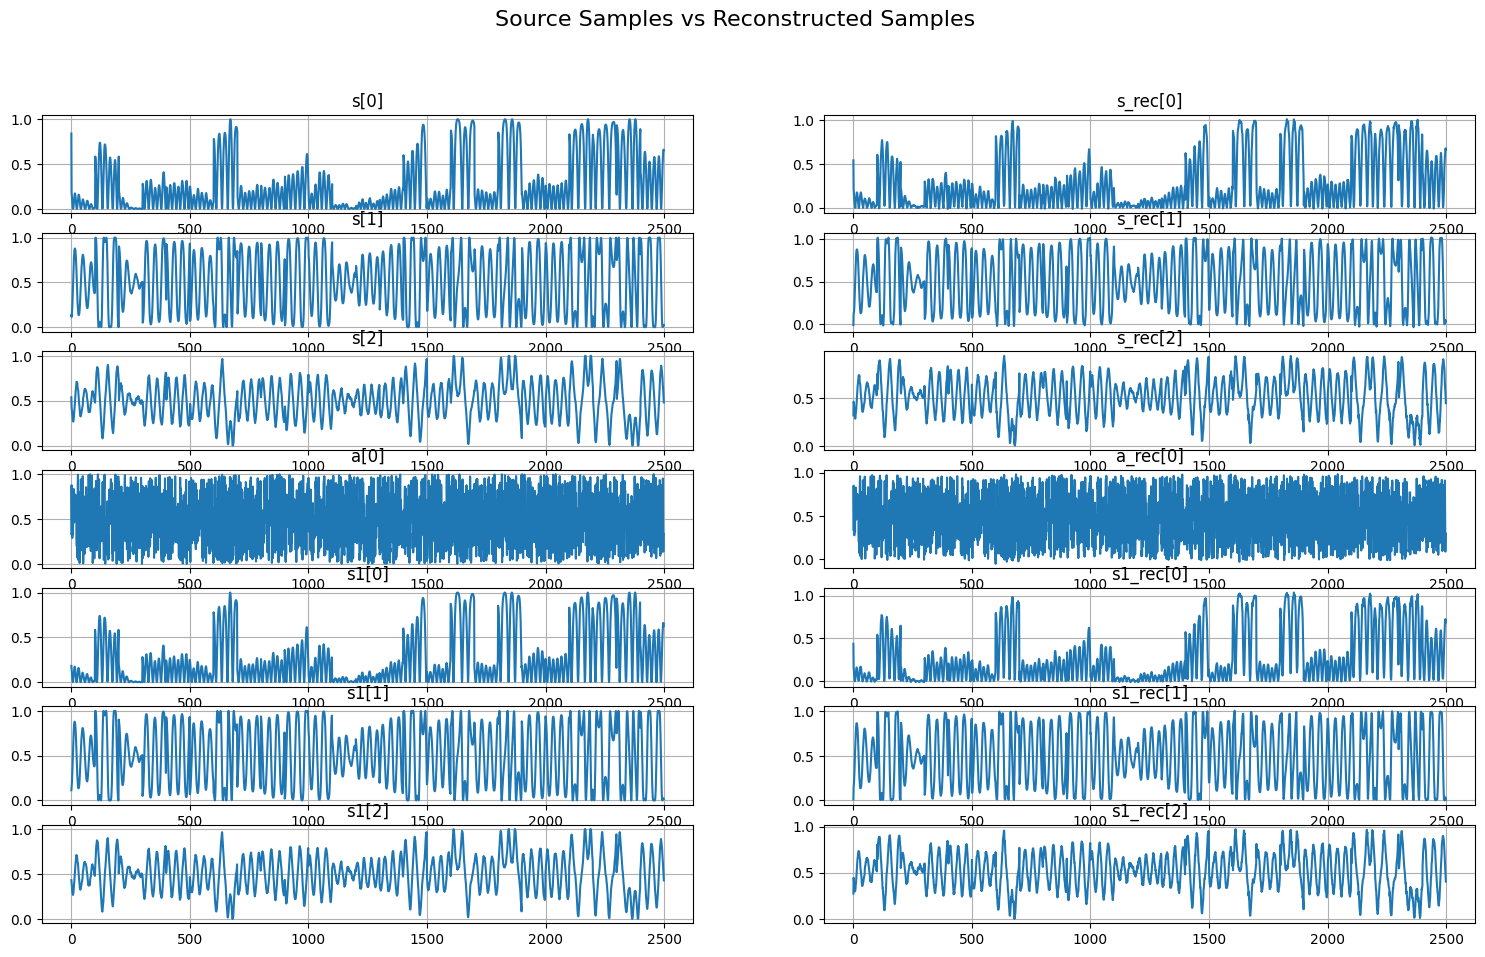

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2*s_s_size+s_a_size, 2)

fig.suptitle('Source Samples vs Reconstructed Samples', fontsize=16)

for i in range(s_s_size):
    index_data = i
    axs[i, 0].plot(s[:,i].detach().numpy())
    axs[i, 0].set_title('s['+str(i)+"]")
    axs[i, 0].grid()
    axs[i, 1].plot(s_rec[:,i].detach().numpy())
    axs[i, 1].set_title('s_rec['+str(i)+"]")
    axs[i, 1].grid()
for i in range(s_s_size,s_a_size+s_s_size):
    index_data = i-s_s_size 
    axs[i, 0].plot(a[:,index_data].detach().numpy())
    axs[i, 0].set_title('a['+str(index_data)+"]")
    axs[i, 0].grid()
    axs[i, 1].plot(a_rec[:,index_data].detach().numpy())
    axs[i, 1].set_title('a_rec['+str(index_data)+"]")
    axs[i, 1].grid
for i in range(s_a_size+s_s_size,s_a_size+2*s_s_size):
    index_data = i-s_s_size-s_a_size
    axs[i, 0].plot(s1[:,index_data].detach().numpy())
    axs[i, 0].set_title('s1['+str(index_data)+"]")
    axs[i, 0].grid()
    axs[i, 1].plot(s1_rec[:,index_data].detach().numpy())
    axs[i, 1].set_title('s1_rec['+str(index_data)+"]")
    axs[i, 1].grid()
fig.set_size_inches(18.5, 10.5)
plt.show()

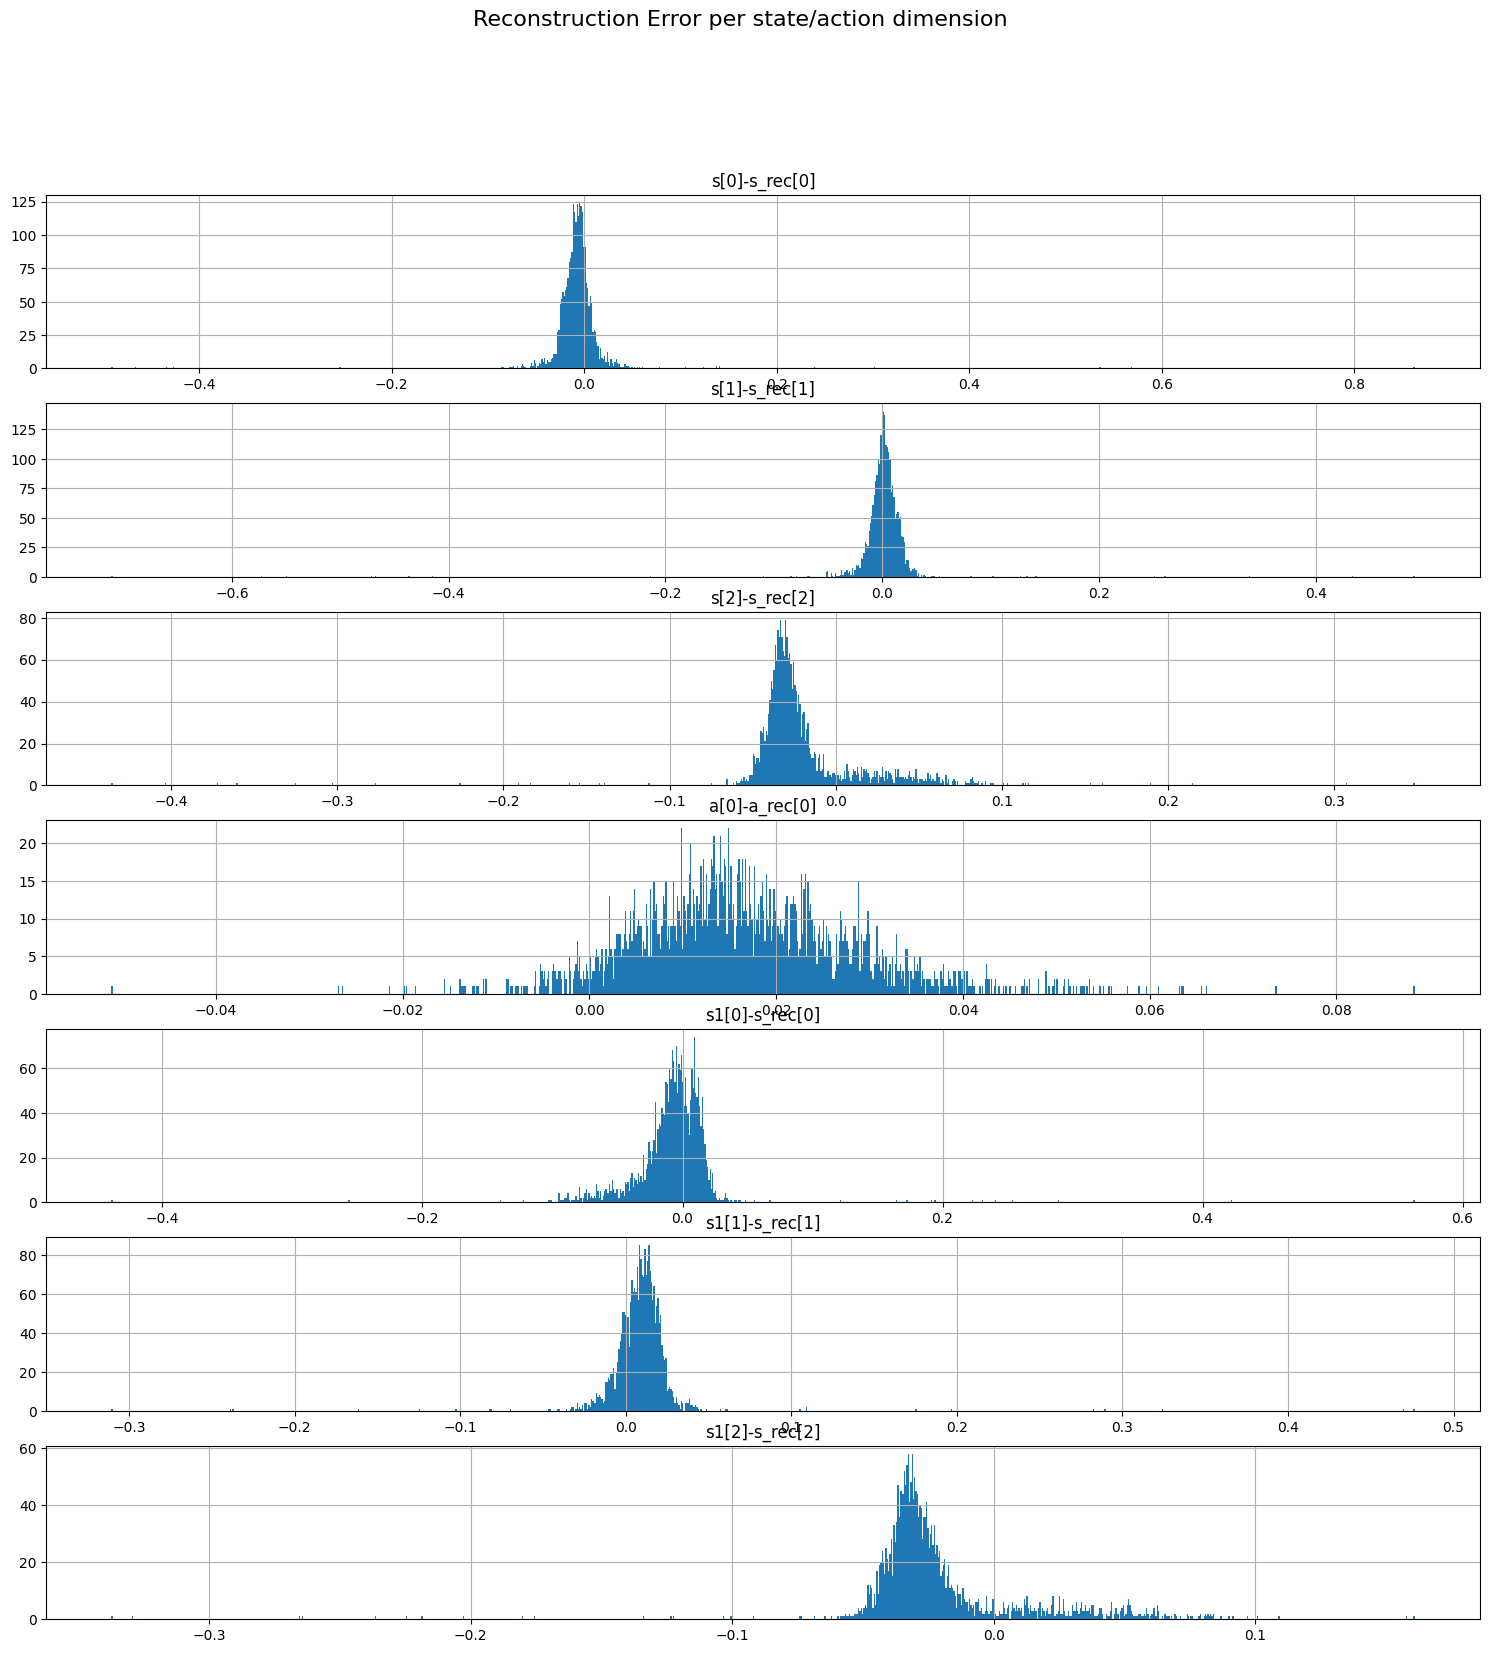

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2*s_s_size+s_a_size, 1)

err_s = s-s_rec
err_a = a-a_rec
err_s1 = s1-s1_rec

fig.suptitle('Reconstruction Error per state/action dimension', fontsize=16)

for i in range(s_s_size):
    axs[i].hist(err_s[:,i].detach().numpy(), bins=1000)
    axs[i].set_title('s['+str(i)+"]-s_rec["+str(i)+"]")
    axs[i].grid()
for i in range(s_s_size,s_a_size+s_s_size):
    index_data = i-s_s_size 
    axs[i].hist(err_a[:,index_data].detach().numpy(), bins=1000)
    axs[i].set_title('a['+str(index_data)+']-a_rec['+str(index_data)+"]")
    axs[i].grid()
for i in range(s_a_size+s_s_size,s_a_size+2*s_s_size):
    index_data = i-s_s_size-s_a_size
    axs[i].hist(err_s1[:,index_data].detach().numpy(), bins=1000)
    axs[i].set_title('s1['+str(index_data)+"]-s_rec["+str(index_data)+"]")
    axs[i].grid()
fig.set_size_inches(18.5, 18.5)
plt.show()

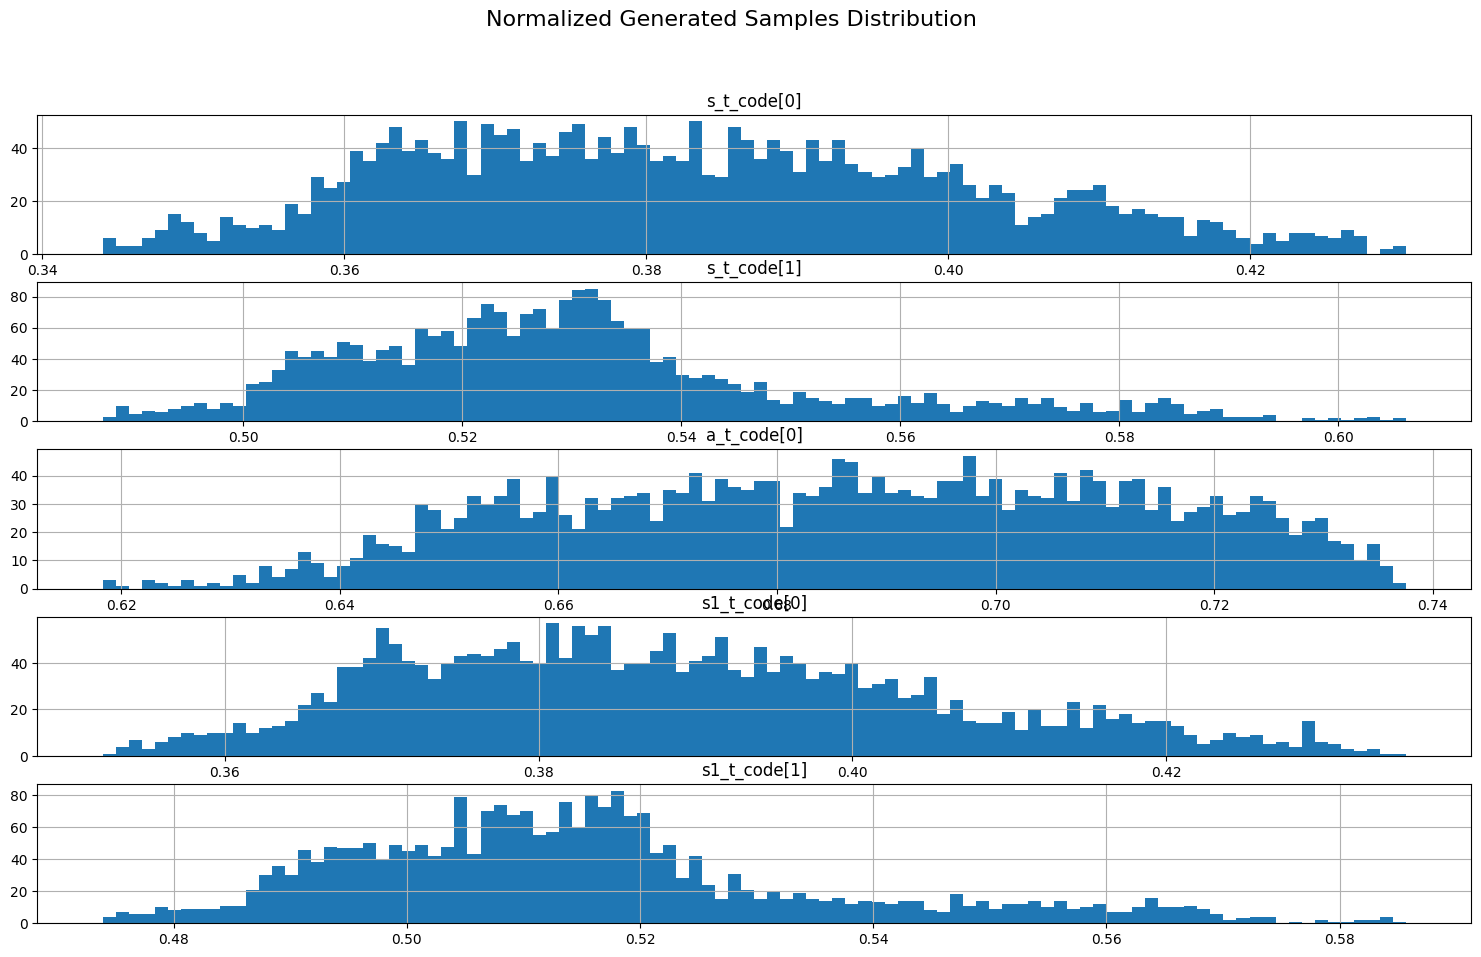

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2*t_s_size+t_a_size, 1)

fig.suptitle('Normalized Generated Samples Distribution', fontsize=16)

for i in range(t_s_size):
    axs[i].hist(s_t_code[:,i].detach().numpy(), bins=100)
    axs[i].set_title('s_t_code['+str(i)+"]")
    axs[i].grid()
for i in range(t_s_size,t_a_size+t_s_size):
    index_data = i-t_s_size 
    axs[i].hist(a_t_code[:,index_data].detach().numpy(), bins=100)
    axs[i].set_title('a_t_code['+str(index_data)+']')
    axs[i].grid()
for i in range(t_a_size+t_s_size,t_a_size+2*t_s_size):
    index_data = i-t_s_size-t_a_size
    axs[i].hist(s1_t_code[:,index_data].detach().numpy(), bins=100)
    axs[i].set_title('s1_t_code['+str(index_data)+"]")
    axs[i].grid()
fig.set_size_inches(18.5, 10.5)
plt.show()

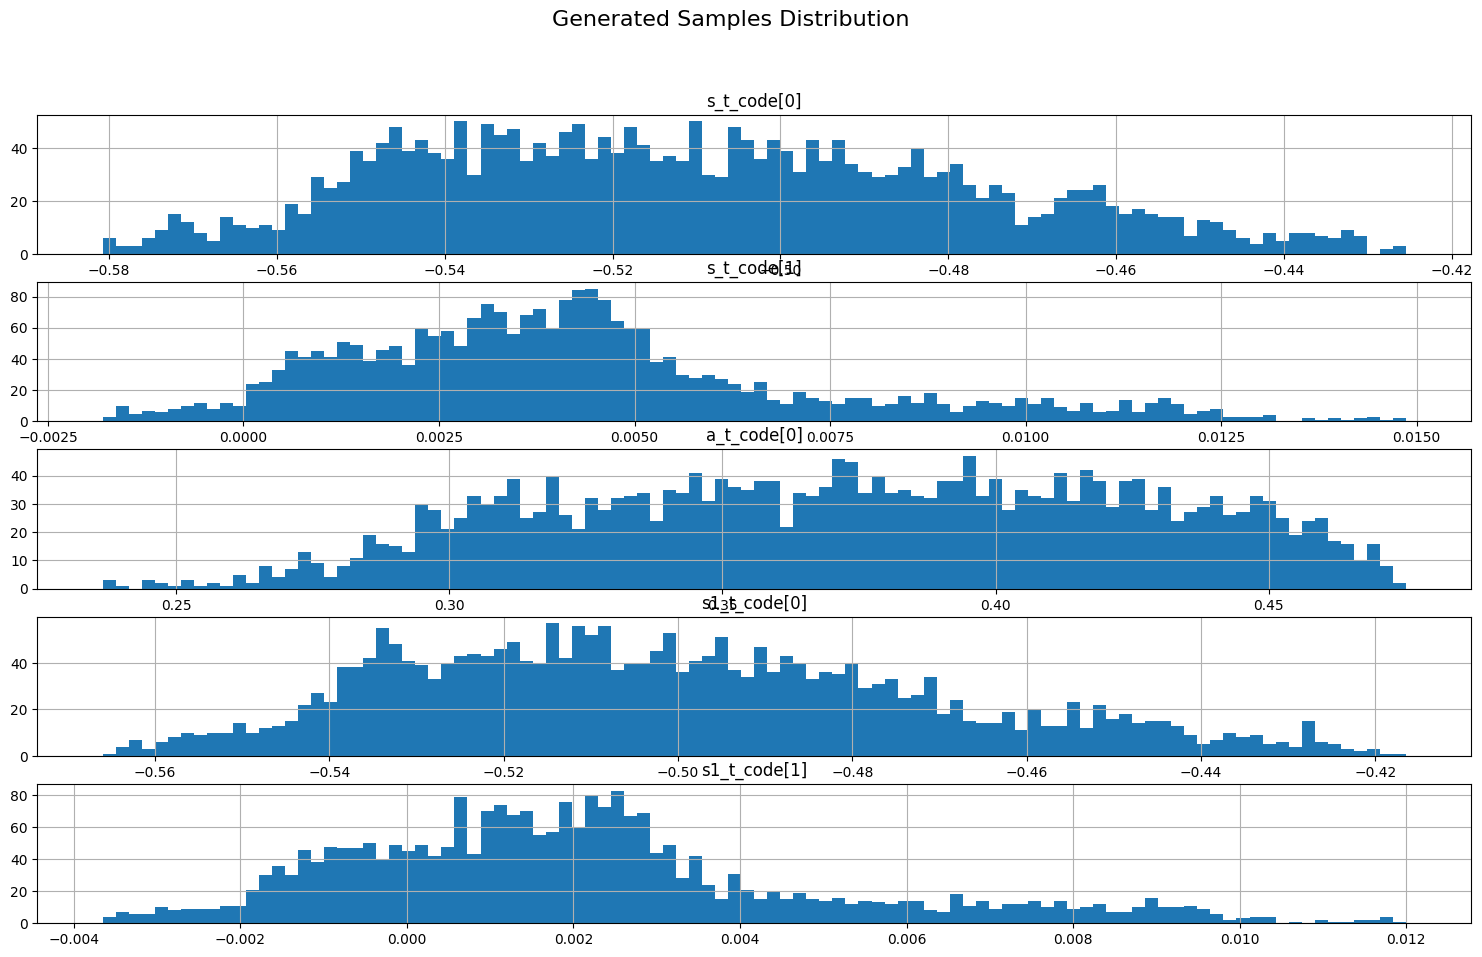

In [11]:
r_code=torch.zeros(len(s1_t_code),1)
synth_data_formatter = RLDatasetFormatter([s_t_code,a_t_code,r_code,s1_t_code]).denormalize_data(t_s_max, t_s_min, t_a_max, t_a_min)

s_t_code, a_t_code, s1_t_code = torch.split(synth_data_formatter.transition_identity()[:][0], [t_s_size, t_a_size, t_s_size],1)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2*t_s_size+t_a_size, 1)

fig.suptitle('Generated Samples Distribution', fontsize=16)

for i in range(t_s_size):
    axs[i].hist(s_t_code[:,i].detach().numpy(), bins=100)
    axs[i].set_title('s_t_code['+str(i)+"]")
    axs[i].grid()
for i in range(t_s_size,t_a_size+t_s_size):
    index_data = i-t_s_size 
    axs[i].hist(a_t_code[:,index_data].detach().numpy(), bins=100)
    axs[i].set_title('a_t_code['+str(index_data)+']')
    axs[i].grid()
for i in range(t_a_size+t_s_size,t_a_size+2*t_s_size):
    index_data = i-t_s_size-t_a_size
    axs[i].hist(s1_t_code[:,index_data].detach().numpy(), bins=100)
    axs[i].set_title('s1_t_code['+str(index_data)+"]")
    axs[i].grid()
fig.set_size_inches(18.5, 10.5)
plt.show()


In [12]:
synth_dataset_t = synth_data_formatter.normalize_data(t_s_max, t_s_min, t_a_max, t_a_min).as_transitions()
dataset_t = data_formatter_t.as_transitions()
train_dataset=synth_dataset_t.merge(dataset_t)

T_hat = TransitionModel(lr=T_lr,
                        s_dim=t_s_size,
                        a_dim=t_a_size)
T_hat.train_model(dataset=train_dataset,
              batch_size=T_batch_size,
              epochs=T_epochs,
              logs_dir=LOG_DIR+'/T_hat')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: pend2mc_TD_2/T_hat/lightning_logs

  | Name           | Type       | Params
----------------------------------------------
0 | loss_criterion | L1Loss     | 0     
1 | statefc        | Sequential | 8.5 K 
2 | actionfc       | Sequential | 8.4 K 
3 | predfc         | Sequential | 16.6 K
----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:262: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  "Could not log computational graph to TensorBoard: The `model.example_input_array` attribute

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 99: 100%|██████████| 30/30 [00:00<00:00, 93.34it/s, loss=0.00524, v_num=0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 30/30 [00:00<00:00, 91.02it/s, loss=0.00524, v_num=0]


In [13]:
dataset_t_ext = data_formatter_t_ext.as_transitions()

sa, s1 = dataset_t_ext[:]
T_fun = T.as_dict()['func']
T_hat_fun = T_hat.as_dict()['func']
with torch.no_grad():
    s1_T = T_fun(sa)
    s1_hat_T = T_hat_fun(sa)

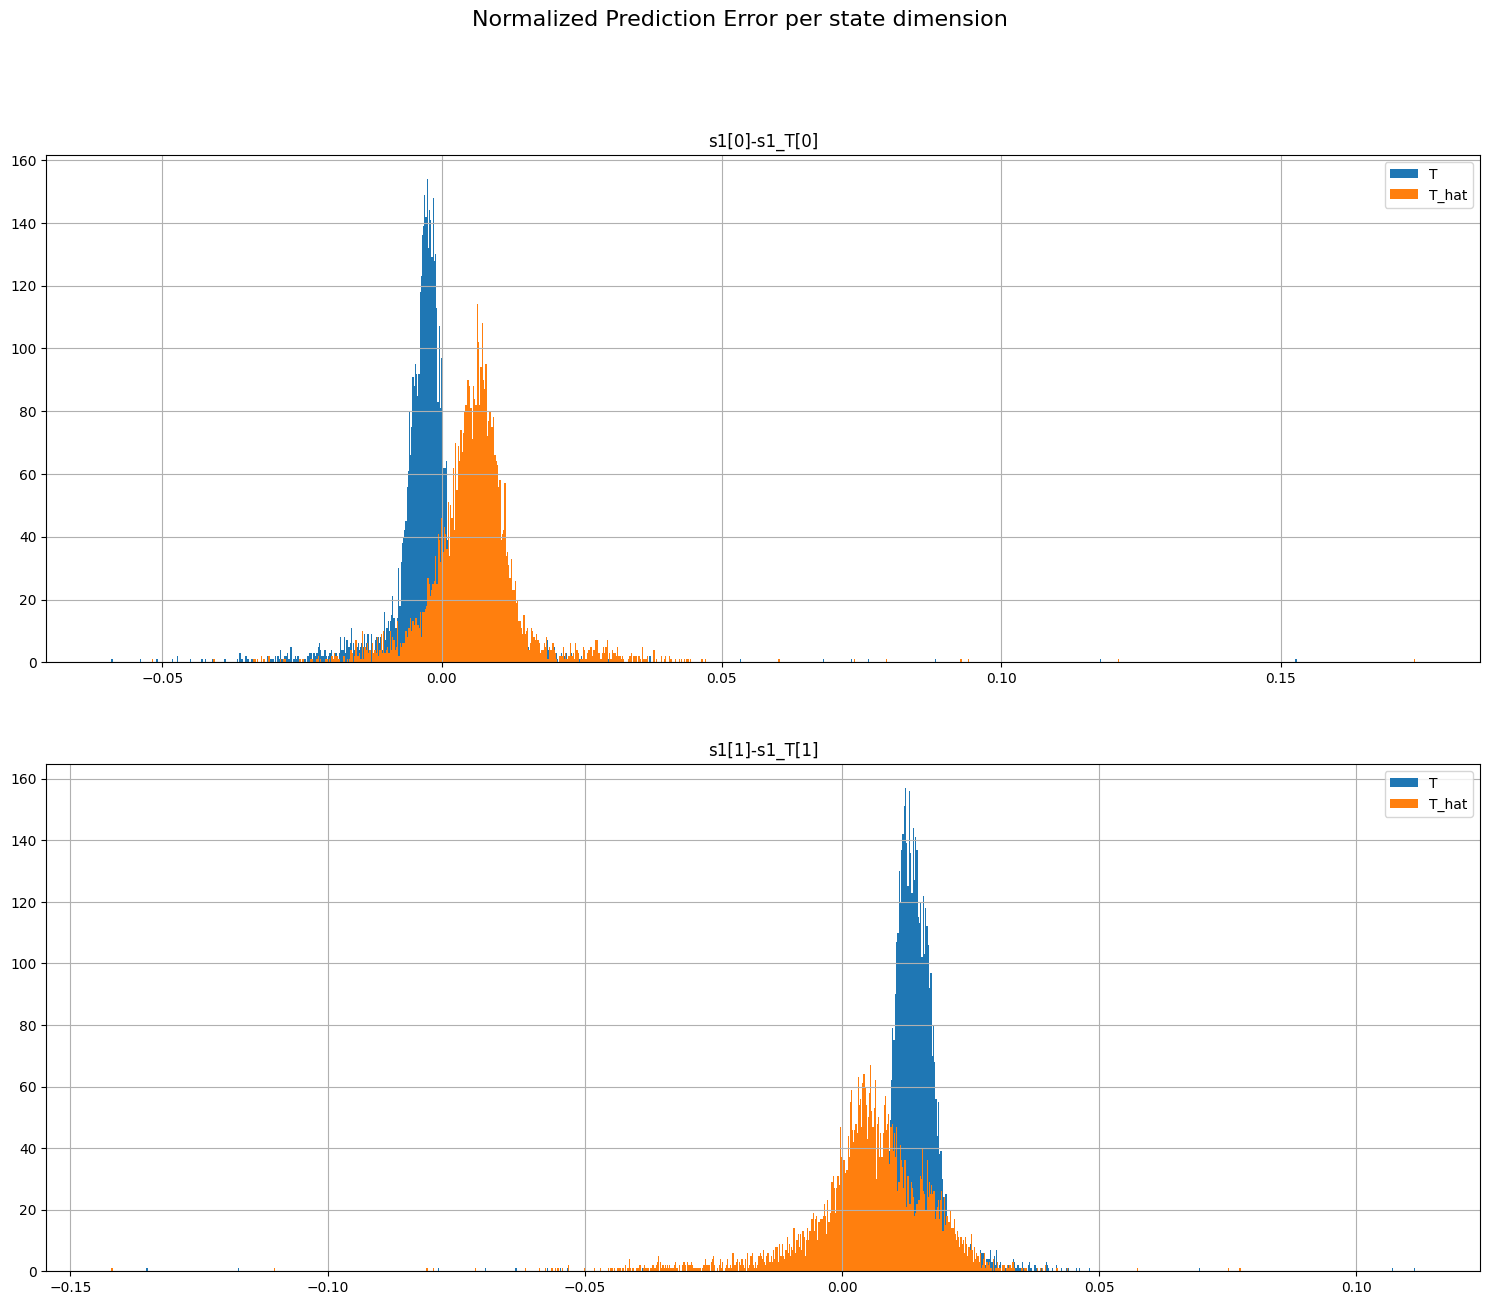

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(t_s_size, 1)


fig.suptitle('Normalized Prediction Error per state dimension', fontsize=16)

err_T = s1-s1_T
err_hat_T = s1-s1_hat_T

for i in range(t_s_size):
    axs[i].hist(err_T[:,i].detach().numpy(), bins=1000, label="T")
    axs[i].hist(err_hat_T[:,i].detach().numpy(), bins=1000, label="T_hat")
    axs[i].set_title('s1['+str(i)+"]-s1_T["+str(i)+"]")
    axs[i].grid()
    axs[i].legend()

fig.set_size_inches(18.5, 14.5)
plt.show()

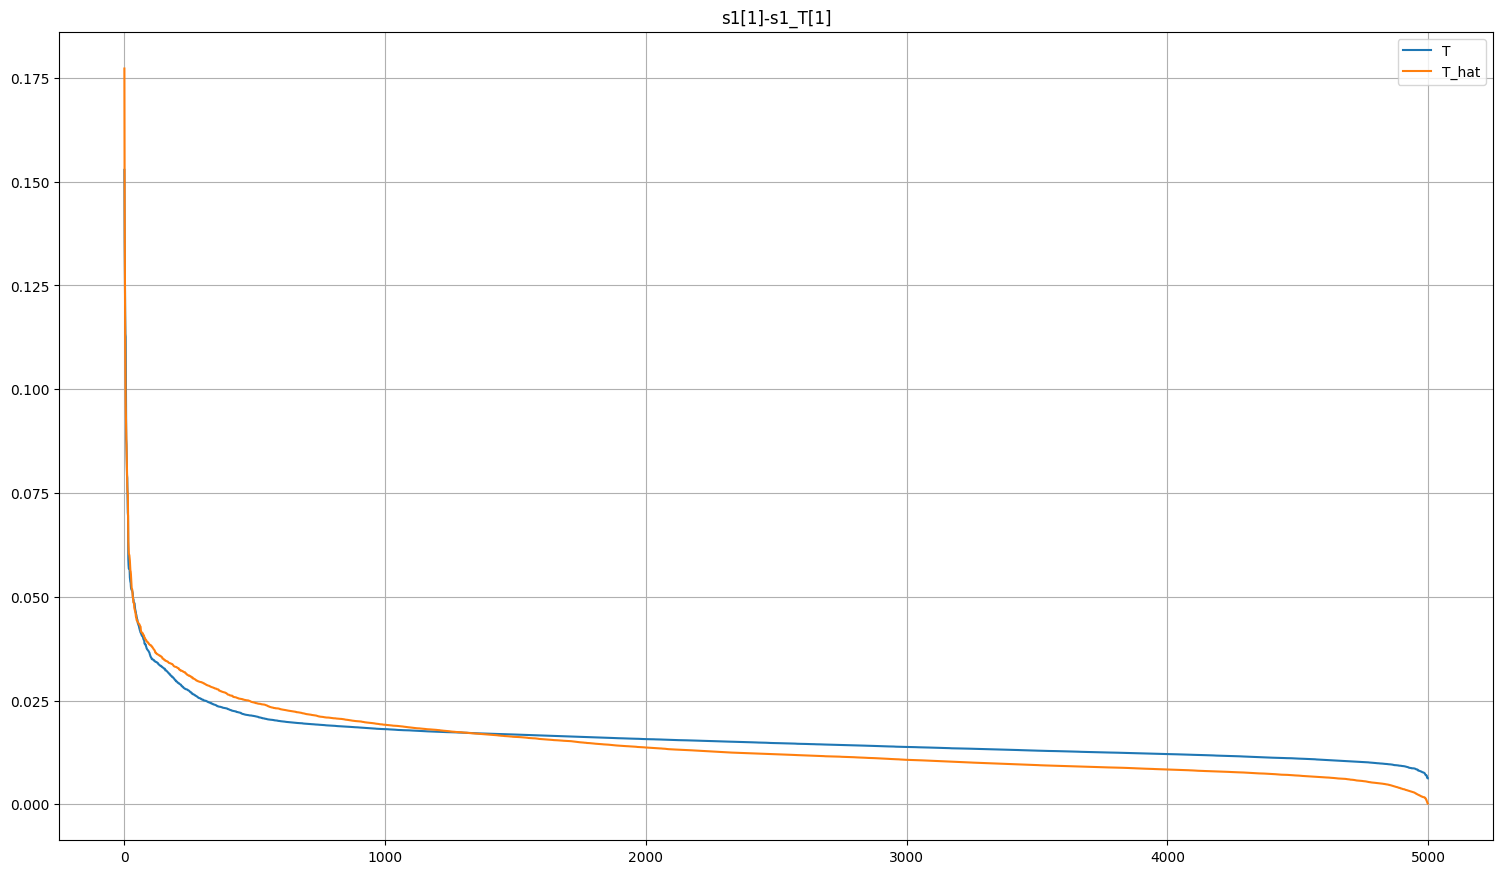

In [15]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (18.5, 10.5)

fig.suptitle('Normalized Mean Squared Error per state (sorted)', fontsize=16)
err_T = torch.norm(s1-s1_T, dim=1)
err_hat_T = torch.norm(s1-s1_hat_T, dim=1)

plt.plot(sorted(err_T.detach().numpy(),reverse=True), label='T')
plt.plot(sorted(err_hat_T.detach().numpy(),reverse=True), label="T_hat")
plt.title('s1['+str(i)+"]-s1_T["+str(i)+"]")
plt.legend()
plt.grid()
plt.show()

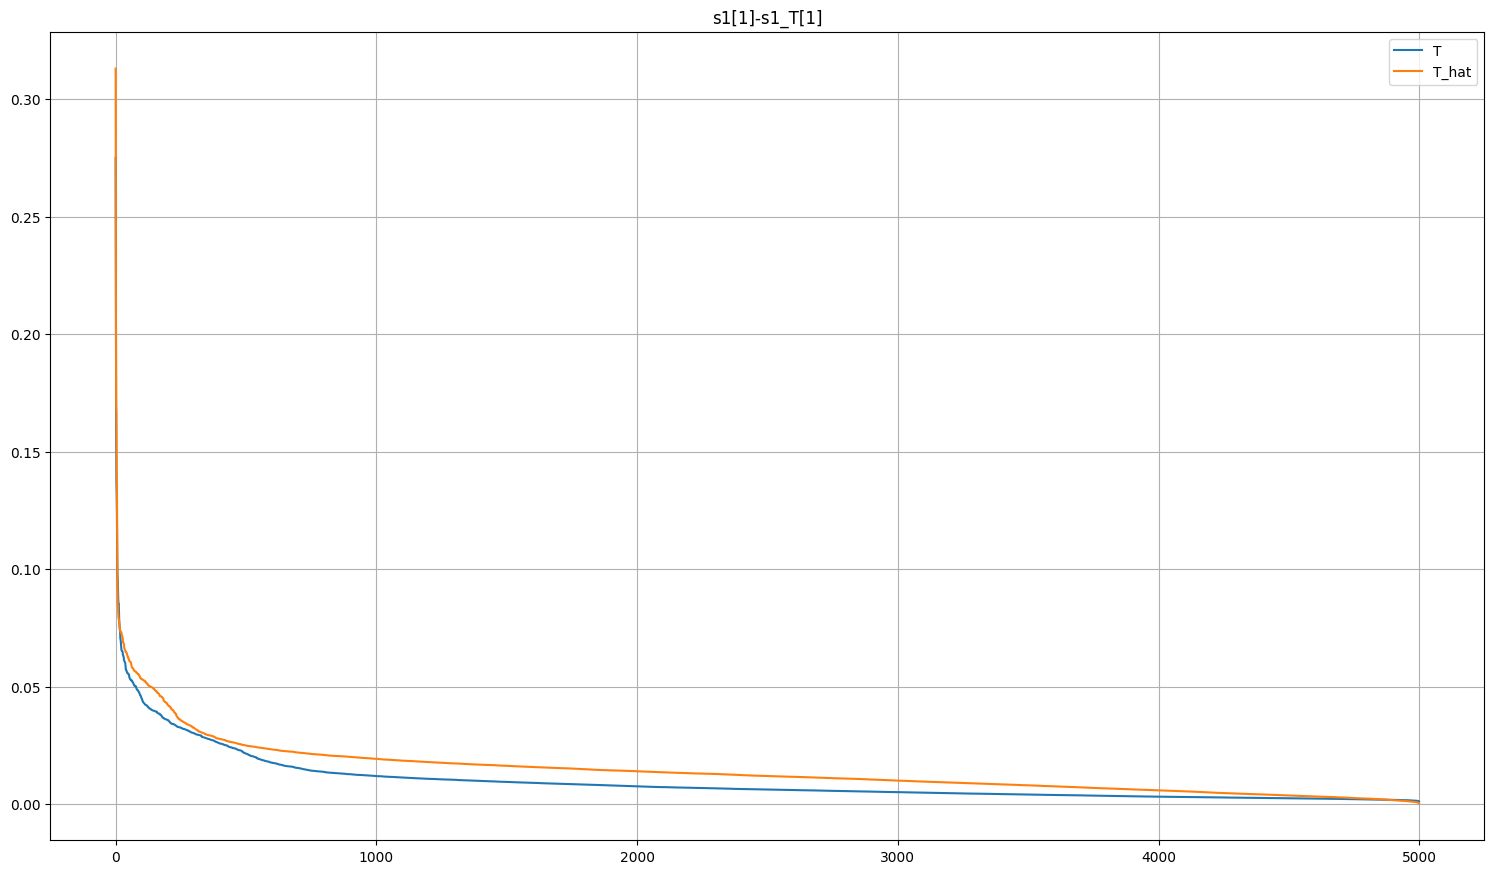

In [16]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (18.5, 10.5)

plt.title('Mean Squared Error per state (sorted)', fontsize=16)
den_s1_T = s1_T * (t_s_max - t_s_min) + t_s_min
den_s1_hat_T = s1_hat_T * (t_s_max - t_s_min) + t_s_min
den_s1 = s1 * (t_s_max - t_s_min) + t_s_min
err_T = torch.norm(den_s1-den_s1_T, dim=1)
err_hat_T = torch.norm(den_s1-den_s1_hat_T, dim=1)

plt.plot(sorted(err_T.detach().numpy(),reverse=True), label='T')
plt.plot(sorted(err_hat_T.detach().numpy(),reverse=True), label="T_hat")
plt.title('s1['+str(i)+"]-s1_T["+str(i)+"]")
plt.legend()
plt.grid()
plt.show()